In [44]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error

from scipy.stats import boxcox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [45]:
df = pd.read_csv('data/eps_quarter.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [47]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [48]:
df.tail()

,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


## 📌 Plot the Time Series Data

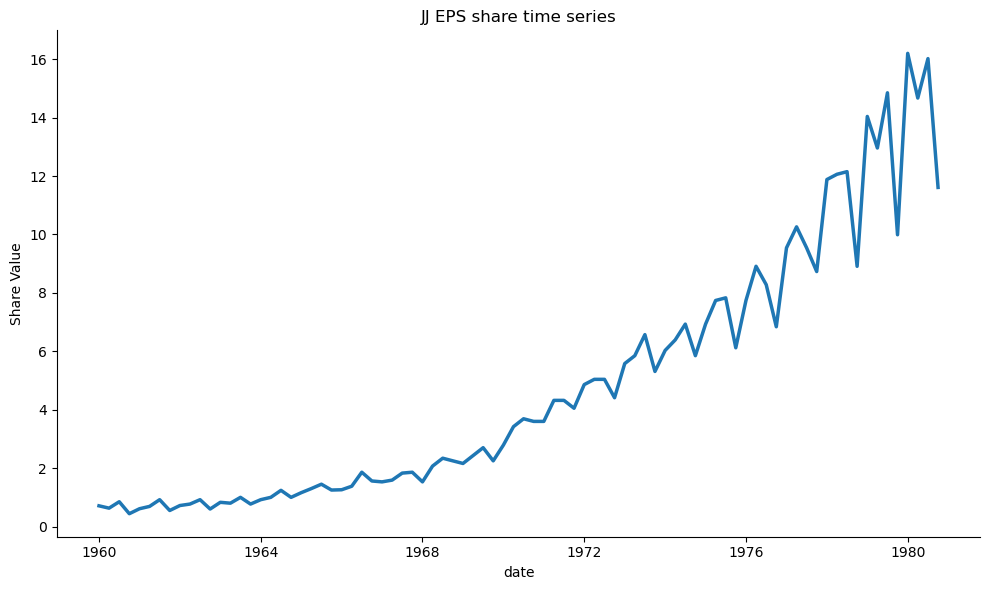

In [49]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'])
plt.title('JJ EPS share time series')

plt.xlabel('date')
plt.ylabel('Share Value')

plt.tight_layout()
plt.show()

## Check for Stationarity (Dickey-Fuller Test)

In [50]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series)

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [51]:
adf_test(df['data'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic  2.742017
               p-value  1.000000
           # Lags Used 11.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 1.00000 > 0.05)


In [52]:

#split into train and test sets
X = df.values
size = int(len(X) * 0.96)
train, test = X[0:size], X[size:len(X)]


In [53]:
print(f"Training Size: {len(train)} quarters")
print(f"Test Size: {len(test)} quarters")

Training Size: 80 quarters
Test Size: 4 quarters


## Elimination of Non Stationarity

### Apply differencing

In [54]:
# create a differenced series
def trend_difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [55]:
# Apply differencing on just one column, assuming 'inflation' is the column of interest
eps_diff = trend_difference(df['data'].values, interval=1)

### Adfuller test to check stationarity of differenced series

In [56]:
adf_test(eps_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -0.407410
               p-value  0.908854
           # Lags Used 10.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.90885 > 0.05)


In [64]:
#second order differencing
eps_diff2  = trend_difference(eps_diff, interval=1)

In [58]:
adf_test(eps_diff2)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -3.585163
               p-value  0.006051
           # Lags Used  9.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00605 ≤ 0.05)


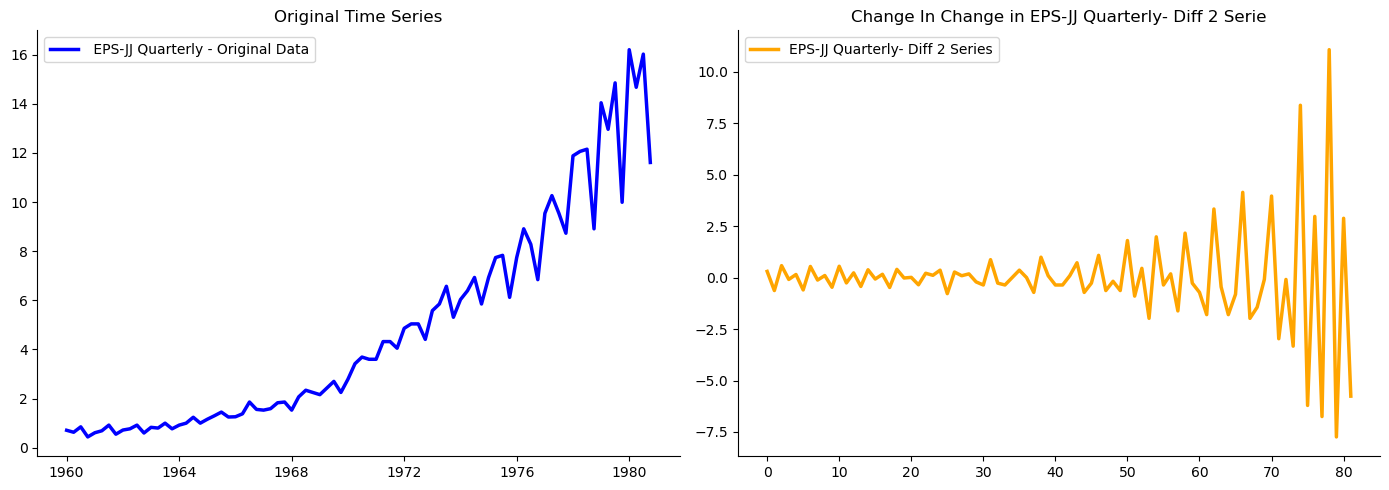

In [59]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label=' EPS-JJ Quarterly - Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# transformed series
axes[1].plot(eps_diff2, label="EPS-JJ Quarterly- Diff 2 Series", color='orange')
axes[1].set_title('Change In Change in EPS-JJ Quarterly- Diff 2 Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

## Determine Lag Order (p,q,d=2)

### ACF PACF for Initial Analysis

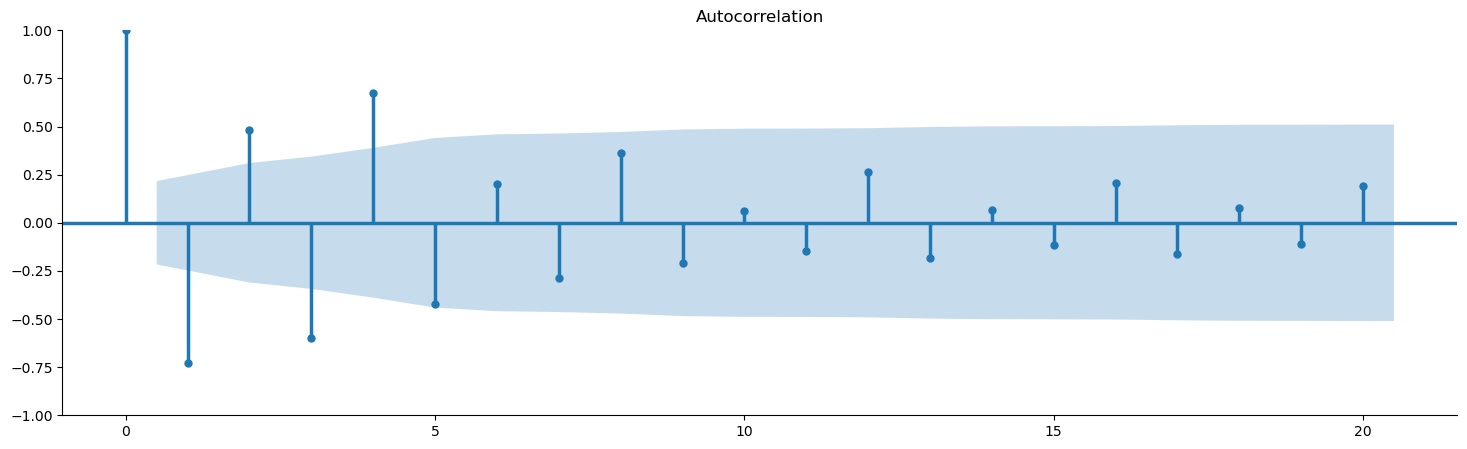

In [65]:
plot_acf(eps_diff2)
plt.show()

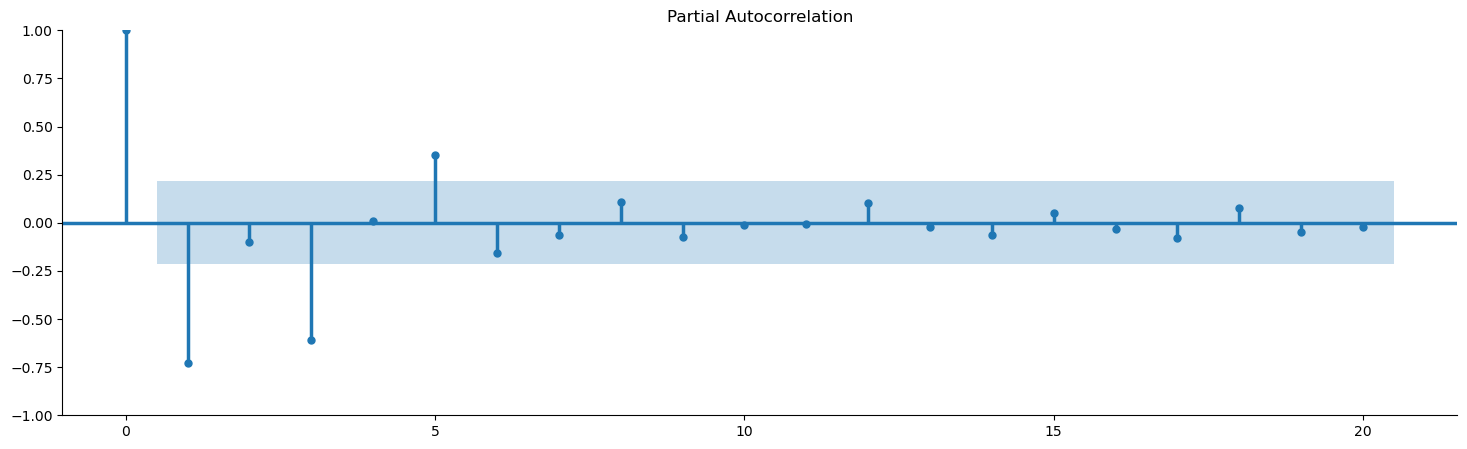

In [66]:
plot_pacf(eps_diff2)
plt.show()

### AIC Criteria for best order selection

In [67]:
from tqdm import tqdm
import pandas as pd
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

def optimize_arima(endog, order_list, d):
    results = []
    
    for order in tqdm(order_list, desc="Optimizing ARIMA models"):
        try:
            # Fit ARIMA model
            model = ARIMA(
                endog, 
                order=(order[0], d, order[1])
            ).fit()
        except Exception as e:
            print(f"Model {order} failed with error: {e}")
            continue
        
        # Collect AIC for the model
        aic = model.aic
        results.append([order, aic])
        
    # If no valid models were found
    if not results:
        print("No valid models were found.")
        return pd.DataFrame()
    
    # Create a DataFrame with results
    result_df = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    
    # Sort in ascending order based on AIC
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [68]:
from itertools import product

p_range = range(0, 4, 1)
q_range = range(0, 4, 1)
d = 0

myorder_list = list(product(p_range, q_range))

In [70]:
# Ensure the function name is correct
result_df = optimize_arima(eps_diff2, myorder_list, d)
result_df

Optimizing ARIMA models: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]


,"(p, q)",AIC
0,"(3, 3)",114.257663
1,"(3, 2)",119.505809
2,"(3, 1)",123.030460
3,"(3, 0)",162.730028
4,"(0, 3)",214.354185
5,"(2, 2)",234.994642
6,"(1, 2)",236.443248
7,"(0, 2)",243.461766
8,"(2, 3)",248.194747
9,"(1, 3)",256.516779


## ARIMA Model

In [71]:
model=ARIMA(train,order=(3,2,3))
model_fit=model.fit()

In [72]:
residuals = model_fit.resid
residuals

array([ 0.71      , -0.43499719,  0.29998532, -0.36607003,  0.00457616,
        0.16676061,  0.11543212,  0.07110164,  0.04428537,  0.01042148,
       -0.06150583, -0.00390023,  0.07622172, -0.02802591,  0.01309528,
        0.11223685,  0.00467339,  0.08847952,  0.13767371,  0.07096584,
        0.05142776,  0.11324643,  0.00876784,  0.02049929, -0.11206353,
       -0.1088902 ,  0.27987374,  0.12062023, -0.03955536, -0.06366254,
       -0.24183551,  0.13629282, -0.14927134,  0.27774383,  0.32405332,
        0.03947968,  0.23188801, -0.0178952 , -0.05457475, -0.35714376,
        0.34659666,  0.72049598,  0.42435951,  0.56966349, -0.03962148,
        0.01852058, -0.12439471, -0.3021602 ,  0.5946913 ,  0.00281317,
       -0.20938594, -0.42589922,  0.08931933,  0.23232556,  0.79179066,
       -0.06792648, -0.63101061, -0.22697203, -0.19897572, -0.09422909,
        0.29604226,  0.68252069,  0.01649786, -0.77028473,  0.07604981,
        0.64643059, -0.37538857, -0.2432715 ,  1.14182202,  0.49

In [73]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 -50.635
Date:                Fri, 28 Feb 2025   AIC                            115.269
Time:                        09:05:26   BIC                            131.766
Sample:                             0   HQIC                           121.873
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9985      0.037    -26.911      0.000      -1.071      -0.926
ar.L2         -0.9873      0.040    -24.959      0.000      -1.065      -0.910
ar.L3         -0.9760      0.026    -37.906      0.0

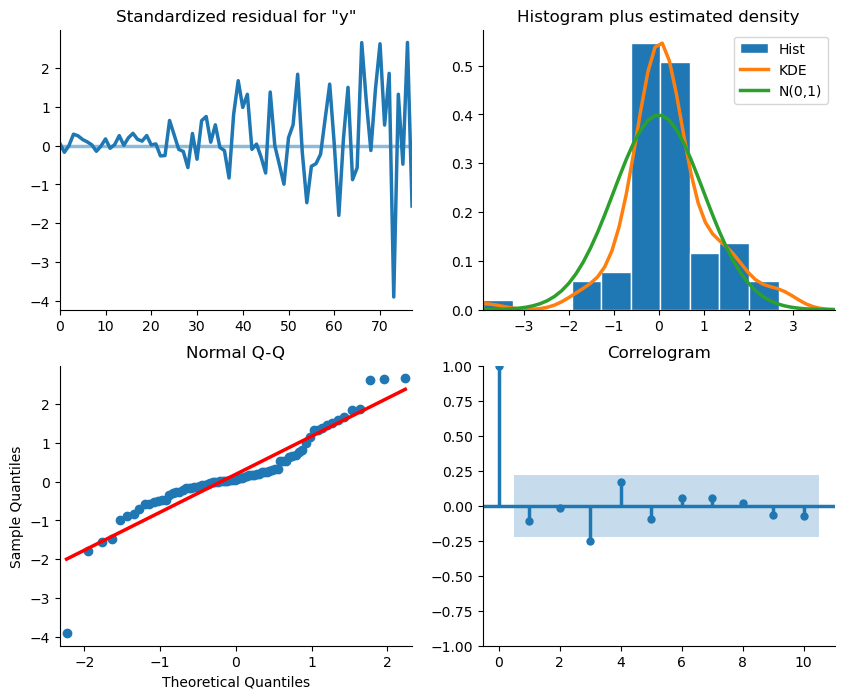

In [74]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

history = [x for x in train]  # Initial history from training set
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(3,2,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"Predicted={yhat}, Expected={obs}")



Predicted=15.851246725227554, Expected=[16.2]
Predicted=14.41151152179686, Expected=[14.67]
Predicted=16.560155465850784, Expected=[16.02]
Predicted=11.76517229491381, Expected=[11.61]


In [60]:
model = ARIMA(train, order=(3,2,3))
model_fit = model.fit()
residuals = model_fit.resid

In [61]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -70.353
Date:                Fri, 28 Feb 2025   AIC                            154.706
Time:                        08:35:26   BIC                            171.292
Sample:                             0   HQIC                           161.351
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0350      0.045    -23.064      0.000      -1.123      -0.947
ar.L2         -1.0195      0.051    -20.087      0.000      -1.119      -0.920
ar.L3         -0.9681      0.040    -24.436      0.0

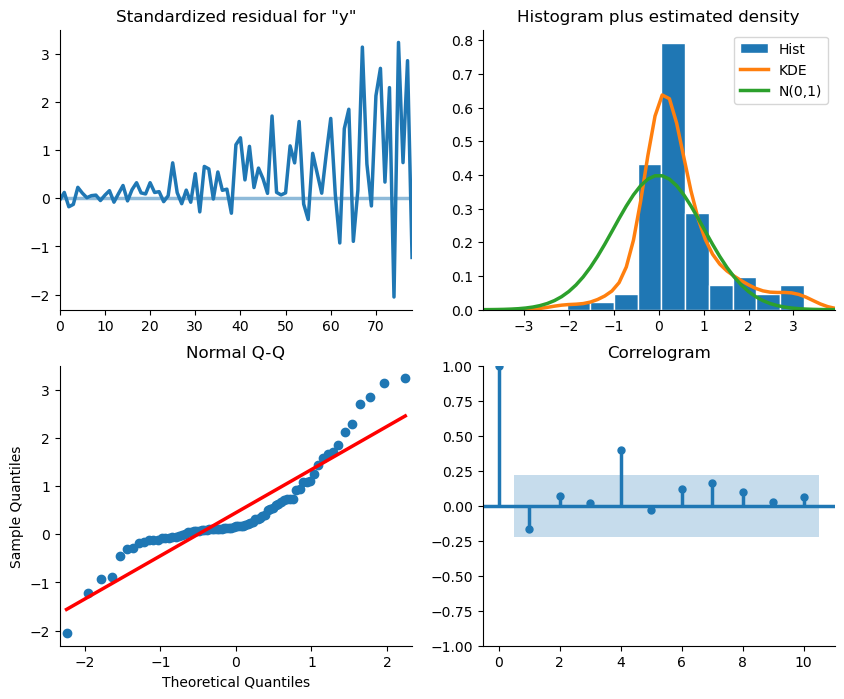

In [62]:
model_fit.plot_diagnostics(figsize=(10, 8));

## 🔹 Evaluate Model

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

history = [x for x in train]  # Initial history from training set
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(3,2,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"Predicted={yhat}, Expected={obs}")



Predicted=15.851246725227554, Expected=[16.2]
Predicted=14.41151152179686, Expected=[14.67]
Predicted=16.560155465850784, Expected=[16.02]
Predicted=11.76517229491381, Expected=[11.61]
